In [1]:
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.tools import freeze_graph
from IPython.display import Image,display

In [2]:
print(tf.__version__)

1.13.1


Download the Dataset from this link https://www.cs.toronto.edu/~kriz/cifar.html

In [3]:
Data_path ="cifar-10-python/cifar-10_png/"
path = 'model_outputs/'

In [4]:
def get_one_hot_label(a):
    return np.eye(10)[a]

In [5]:
def get_data():
    
    with open(Data_path+"train_cifar-10.txt","r") as file:
        lines = file.readlines()
        trainX,trainY = [],[]

        for line in lines:
            data = line.split()
            x,y = data[0], data[1]
            trainX.append(image.img_to_array(image.load_img(Data_path+x, target_size=(32, 32)))/255)
            trainY.append(get_one_hot_label(int(y)))

        return np.array(trainX),np.array(trainY)


In [6]:
trainX,trainY = get_data()
print(trainX.shape , trainY.shape)

(50000, 32, 32, 3) (50000, 10)


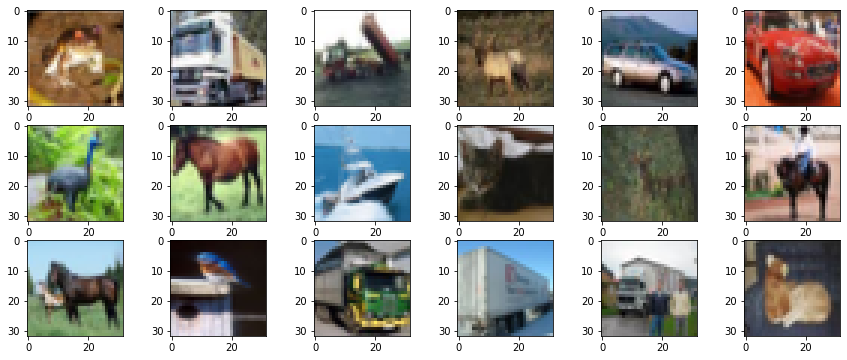

In [7]:
fig=plt.figure(figsize=(15, 6))
columns = 6
rows = 3
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(trainX[i])
plt.show()

In [8]:
def model(inputs):
    
    
    with tf.variable_scope('conv1') as scope:
        weights = tf.get_variable('weights',
                                  shape = [3,3,3, 16],
                                  dtype = tf.float32, 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1,dtype=tf.float32))
        biases =  tf.get_variable('biases',
                                  shape=[16],
                                  dtype=tf.float32,
                                  initializer=tf.constant_initializer(0.1))

        conv = tf.nn.conv2d(inputs, weights, strides=[1,1,1,1], padding='SAME')
        add_bias = tf.nn.bias_add(conv, biases)

        conv1 = tf.nn.relu(add_bias, name= scope.name)

        pool1 = tf.nn.max_pool(conv1, ksize=[1,3,3,1],strides=[1,2,2,1],
                               padding='SAME', name='pooling1')
        

    with tf.variable_scope("conv2") as scope:
        
        weights = tf.get_variable("weights",
                                 shape = [3,3,16,32],
                                 dtype = tf.float32,
                                 initializer = tf.truncated_normal_initializer(stddev=0.1,dtype = tf.float32))
        biases =  tf.get_variable("biases",
                                 shape = [32],
                                 dtype = tf.float32,
                                 initializer = tf.constant_initializer(0.1))

        conv = tf.nn.conv2d(pool1,weights,strides=[1,1,1,1],padding = "SAME")
        add_bias = tf.nn.bias_add(conv,biases)

        conv2 = tf.nn.relu(add_bias,name = "conv2")

        pool2 = tf.nn.max_pool(conv2,ksize=[1,3,3,1], strides=[1,1,1,1],
                               padding='SAME',name='pooling2')

    with tf.variable_scope('fc3') as scope:
        
        layer_shape = pool2.get_shape()
        num_features = layer_shape[1:4].num_elements()
        flatten_layer = tf.reshape(pool2, [-1, num_features])
    
        flatten_dim = flatten_layer.get_shape()[1]

        weights = tf.get_variable('weights',
                                  shape=[flatten_dim,128],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases =  tf.get_variable('biases',
                                  shape=[128],
                                  dtype=tf.float32, 
                                  initializer=tf.constant_initializer(0.1))

        fc3 = tf.nn.relu(tf.matmul(flatten_layer, weights) + biases, name=scope.name)    

    with tf.variable_scope('fc4') as scope:
        weights = tf.get_variable('weights',
                                  shape=[128,128],
                                  dtype=tf.float32, 
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases = tf.get_variable('biases',
                                 shape=[128],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        fc4 = tf.nn.relu(tf.matmul(fc3, weights) + biases, name='fc4')


    with tf.variable_scope('output') as scope:

        weights = tf.get_variable('weights5',
                                  shape=[128, 10],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases = tf.get_variable('biases5', 
                                 shape=[10],
                                 dtype=tf.float32, 
                                 initializer=tf.constant_initializer(0.1))
        logits = tf.add(tf.matmul(fc4, weights), biases, name='final_logits')


    return logits

In [9]:
tf.reset_default_graph()
X = tf.placeholder("float", [None,32,32,3],name = "Input")
Y = tf.placeholder("float", [None,10])

logits = model(X)

total_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer=tf.train.GradientDescentOptimizer(0.05).minimize(total_cost)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
predict_outputs_Y = tf.argmax(logits, 1,name = "Argmax",output_type=tf.int32) # at predict time, evaluate the argmax
predict_softmaxs_Y = tf.nn.softmax(logits, 1,name ="Softmax")

In [11]:
def get_accuracy (inputs,labels,sess):
    return np.mean(np.argmax(labels, axis=1) == sess.run(predict_outputs_Y, feed_dict={X: inputs}))

In [12]:
def save_tf_model(sess,path,model_name):

    tf.train.write_graph(sess.graph_def, '.', path+model_name+'.pbtxt')
    print("model protobuf is stored successfully!")

    saver = tf.train.Saver()
    saver.save(sess, path+model_name)
    print("model checkpoint is saved successfully!")


def freeze_tf_model(path,model_name):

    input_graph_path = path+model_name+'.pbtxt'
    checkpoint_path = path+model_name
    input_saver_def_path = ""
    input_binary = False
    output_node_names = "Softmax"
    restore_op_name = "save/restore_all"
    filename_tensor_name = "save/Const:0"
    output_frozen_graph_name = path+'frozen_'+model_name+'.pb'
    clear_devices = True

    freeze_graph.freeze_graph(input_graph_path, input_saver_def_path,
                              input_binary, checkpoint_path, output_node_names,
                              restore_op_name, filename_tensor_name,
                              output_frozen_graph_name, clear_devices, "")
    
    print("model is freezed successfully!")
    
def convert_to_tflite():
    converter = tf.contrib.lite.TocoConverter.from_frozen_graph(path+'frozen_cifar10.pb', ['Input'], ['Softmax'])
    tflite_model = converter.convert()
    open(path+"cifar10.tflite", "wb").write(tflite_model)
    print("Model is written as tflite")

In [13]:
epochs = 20
epoch_cost = []
epoch_acc = []

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

print("Training started")
for epoch in range(epochs):
    total_batch_cost = 0
    acc_list = []
    
    for start, end in zip(range(0, len(trainX), 32), range(32, len(trainX)+1, 32)):
        feed_dict = {X : trainX[start:end] , Y : trainY[start:end]}
        _,y_hat,batch_cost = sess.run([optimizer,predict_softmaxs_Y,total_cost],feed_dict=feed_dict)
        
        acc = np.mean(np.argmax(trainY[start:end], axis=1) == np.argmax(y_hat,axis=1))
        acc_list.append(acc)
        total_batch_cost += batch_cost    
        
    print("Epoch cost is : {} and accuracy is : {} ".format(total_batch_cost,np.mean(acc_list)))

    epoch_cost.append(total_batch_cost)
    epoch_acc.append(np.mean(acc_list))

Training started
Epoch cost is : 3525.2311483621597 and accuracy is : 0.12309939180537773 
Epoch cost is : 2751.1995533704758 and accuracy is : 0.31496078745198464 
Epoch cost is : 2090.823881983757 and accuracy is : 0.5134042893725992 
Epoch cost is : 1740.9142600297928 and accuracy is : 0.6032330345710627 
Epoch cost is : 1496.7995691597462 and accuracy is : 0.6636923815620999 
Epoch cost is : 1305.6982493400574 and accuracy is : 0.709867157490397 
Epoch cost is : 1140.8988940864801 and accuracy is : 0.747099071702945 
Epoch cost is : 1001.5898658335209 and accuracy is : 0.7755681818181818 
Epoch cost is : 879.3914447426796 and accuracy is : 0.8059579065300896 
Epoch cost is : 771.2097424417734 and accuracy is : 0.8273847631241997 
Epoch cost is : 681.1826742514968 and accuracy is : 0.8470310499359796 
Epoch cost is : 622.9821863621473 and accuracy is : 0.8591949423815621 
Epoch cost is : 563.8836980648339 and accuracy is : 0.8725792253521126 
Epoch cost is : 482.38853850215673 and a

In [ ]:
save_tf_model(sess,path,"cifar10")
freeze_tf_model(path,"cifar10")

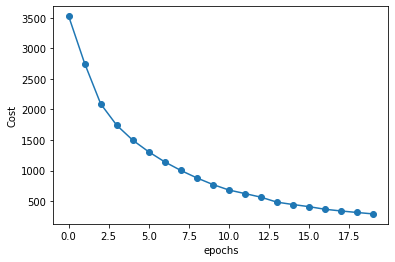

In [18]:
def visulize_cost(epoch_cost):
    indices = [i for i in range(len(epoch_cost))]
    plt.plot(indices,epoch_cost,marker="o")
    plt.xlabel("epochs")
    plt.ylabel("Cost")
    plt.show()
visulize_cost(epoch_cost)

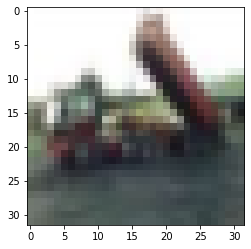

[array([[7.3938310e-02, 1.7091795e-03, 5.1102665e-04, 8.4928190e-03,
        5.3205629e-05, 2.8012021e-04, 3.1917868e-04, 1.1390253e-04,
        7.1694054e-02, 8.4288818e-01]], dtype=float32)]
0.07
0.00
0.00
0.01
0.00
0.00
0.00
0.00
0.07
0.84


In [19]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

graph = load_graph(path+'frozen_cifar10.pb')
# for op in graph.get_operations():
#     print(op.name)
    
x = graph.get_tensor_by_name('import/Input:0')
y = graph.get_tensor_by_name('import/Softmax:0')

image = trainX[2]
plt.imshow(image)
plt.show()
image = np.expand_dims(image,axis=0)

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    output = sess.run([y],feed_dict={x:image})
    print(output)
    
    float_formatter = lambda x: "%.2f" % x
    
    for i in output[0][0]:
        print(float_formatter(i))